In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from tqdm.auto import tqdm
from time import sleep
import scienceplots
import subprocess
pd.set_option('display.max_columns', None)
plt.style.use(['default','notebook']) #plt.style.use(['science','notebook'])
plt.tight_layout()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


<Figure size 800x600 with 0 Axes>

In [115]:

## FUNCTIONS
pi = np.pi
k2 = 4*pi*pi
MS_Types=[0.,1.]
WD_Types=[10.,11.,12.]
MSWD_Types=[0.,1.,10.,11.,12.]

cols =  [
        'N','t','t_n','sur','m1','m1_n','m2','m2_n','m3','m3_n',
        'e1','e1_n','e2','e2_n','a1','a1_n','a2','a2_n','i','i_n','P_in','P_in_n',
        'type1','type2','type3','type1_n','type2_n','type3_n',
        'G1o', 'G1n', 'G2o', 'G2n', 'Gtoto', 'Gtotn', 'cosi_o', 'cosi_n', 'needs_Re', 'Ad_or_Kick'
        ]


def epsilon(a1,a2,e2):
    return (   (a1/a2)* (  e2/(1-e2**2)  )  )

def get_tidal_locked_condition(row):
    a1,Roche1,e1,P1 = row['a1'],row['Roche1'],row['e1'],row['P_in']
    beta,spintot,spin2h = row['beta'],row['spintot'],row['spin2h']
    M_PI = np.pi
    
    tl_crit1 = (a1/Roche1 <= 5 or a1 <= 0.1) 
    tl_crit2 = ( e1 <= 1e-4 )
    tl_crit3 = (a1 <= 0.1 and e1 <= 1e-2)

    tl_condition = ( e1 <= 1e-2 and tl_crit1 and tl_crit2) or tl_crit3
    return tl_condition

def get_t_ekl(m1,m2,m3,e2,P1,P2):
    """
    Characteristic quadrupole timescale fro EKL (eq 27 from review)
    """
    return (8./(15*np.pi))*((m1+m2+m3)/m3)*(P2*P2/P1)*np.sqrt(1-e2*e2)*(1-e2*e2)

# can also use this for a2 if inner binary is in c=
def get_a_n(m1,m2,m2n,e1,EA1,a_i, uk=0,theta=0): #(10) in Lu+2019

    B = (m1+m2n) / (m1+m2)
    a1_ratio = B * (1-e1*np.cos(EA1)) / (  2*B - (1+e1*np.cos(EA1))* (1+uk*uk + 2*uk*np.cos(theta))     )
    return a1_ratio * a_i
"""
"""
def a2_n(m1,m2n,m3,a2,e2,E2):
    M = m1 + m2n + m3
    R = a2( 1 - e2*np.cos(E2) )
    
    fv = k2 * M * (2/R  - 1/a2)
    inv = 2 / (a2*(1-e2*np.cos(E2)))   -  fv*fv / ( k2* (m1+m2n + m3) )
    a2n = 1/inv
    
    return a2n

def get_e1_n(r,vr,a1n,m1,m2n,theta=90): #(19) from Lu et al.
    
    e_squared = 1 - np.power(r*vr*np.sin(theta), 2) / (a1n* k2 * (m1+m2n))
    
    return np.sqrt(e_squared)

def get_e2_n(m1,m2n,m3,a2n,R,V2n, theta=90):
    #theta = np.random.uniform(0,np.pi)
    M = m1 + m2n + m3
    term = np.power(a2n*k2*M  ,-1) * np.power(R*V2n*np.sin(theta),2)
    return 1 - term

def get_i(G1,G2,Gtot):
    cosi = (Gtot**2 - G1**2 - G2**2 ) / (2*G1*G2)
    
    return np.arccos(cosi)*180/pi #in degrees

def get_L_rigid(M, R, spin, shape = 'sphere'):
    if shape == 'sphere': 
        I = (2/5) * M * R**2
    w = 2*pi*spin
    return I*w
    
def get_L1(m1,m2,a1):
    mu = (m1*m2 / (m1+m2) )
    L1 = mu * np.sqrt(k2 * (m1+m2)*a1)
    return L1

def get_h(m1,m2,a,e):
    
    hsqr = k2*(m1+m2)*a * np.sqrt(1-e*e)
    return np.sqrt(hsqr)

def get_G_from_h(m1,m2,h):
    mu = m1*m2 / (m1+m2)
    return mu*h

def get_L2(m1,m2,m3,a2):
    M = m1 + m2 + m3
    mu = m3*(m1+m2) / M
    L2 = mu * np.sqrt(k2*M*a2)
    return L2

def get_G(L,e):
    
    return L * np.sqrt(1-e*e)

def i_from_c(old_masses, new_masses,e1o,e1n,old_Gs,new_Gs):
    
    m1o,m2o,m3o = old_masses
    m1n,m2n,m3n = new_masses
    G1o, G2o = old_Gs
    G1n, G2n = new_Gs
    
    mu1o = (m1o * m2o) / (m1o+m2o)
    mu1n = (m1n * m2n) / (m1n+m2n)

    mu2o = m3o*(m1o + m2o) / (m1o+m2o+m3o) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n

    factor1 = np.sqrt(   (1-e1n*e1n) / (1-e1o*e1o) )
    alpha1 = (mu1n/mu1o) * G1o * factor1
    alpha2 = (mu2n / mu2o) * G2o
    
    cosi_n = 0.5 * (    ( alpha1**2 + alpha2**2 - (G1n**2 + G2n**2) ) / (G1n*G2n - alpha1*alpha2)  )
    
    return np.arccos(cosi_n) *180/pi
    
def new_Gtot_from_i(initial_masses : tuple, new_masses : tuple, G10 : float, G20 : float, i0 : float,
                      e1_i : float, e1_n : float) -> float:
    """Get Gtot new from the old G's

    Args:
        initial_masses (tuple): m1o, m2o, m2o
        new_masses (tuple): m1n, m2n, m3n
        G10 (float): old G1
        G20 (float): old G2
        i0 (float): Old total inclination
        old_eccs (float): e1o,e2o
        new_eccs (float): e1n,e2n
    Returns:
        _type_: new G
    """
    
    m1o, m2o, m3o = initial_masses 
    m1n, m2n, m3n = new_masses
    
    e1o = e1_i
    e1n = e1_n
    
    mu1o = (m1o * m2o) / (m1o+m2o)
    mu1n = (m1n * m2n) / (m1n+m2n)
    
    mu2o = m3o*(m1o + m2o) / (m1o+m2o+m3o) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n
    
    factor1 = np.sqrt( (1-e1n*e1n) / (1-e1o*e1o)     )
    G10_u = G10*factor1

    Gsqr = ( (  (mu1n/mu1o)**2  ) * G10_u**2  )  + ( (  (mu2n/mu2o)**2  ) * G20**2   ) + 2*(mu1n/mu1o)*(mu2n/mu2o) * G10_u*G20*np.cos(i0)
    
    return np.sqrt(Gsqr)

def new_i_from_stuff(initial_masses : tuple, new_masses : tuple, i0 : float,
                      e1_i : float, e1_n : float, e2_i : float,  
                      a1n : float, a2 : float) -> float:
    
    m1 , m2 , m3  = initial_masses 
    m1n, m2n, m3n = new_masses
    
    e1o = e1_i
    e2o = e2_i
    e1n = e1_n
    e2n = e2_i
    #mu1  = (m1  * m2 ) / (m1 +m2 )
    mu1n = (m1n * m2n) / (m1n + m2n)
    
    mu2  = m3 *(m1  + m2 ) / (m1 +m2 +m3 ) #mu2o
    mu2n = m3n*(m1n + m2n) / (m1n+m2n+m3n) #mu2n
    
    L1 = mu1n * np.sqrt(k2*(m1+m2)*a1n)
    L2 = mu2n * np.sqrt(k2*(m1+m2+m3)*a2)
    
    G1n   =  mu1n*np.sqrt((m1n + m2n) * a1n * (1-e1n**2))       #L1 * np.sqrt(1-e1n**2) #mu1n*np.sqrt((m1n + m2n) * a1n * (1-e1n**2)) 
    G2    =  mu2 *np.sqrt((m3 * (m1 + m2) * a2 * (1-e1o**2)))   #L2 * np.sqrt(1-e2n**2) #mu2 *np.sqrt((m3 * (m1 + m2) * a2  * (1-e1o**2))) 
    
    G2n=(mu2n/mu2)*G2
    Gtotn2 = G1n**2 + G2n**2 + 2* G1n * G2n * np.cos(i0*pi/180) 
    
    cosin=(Gtotn2-G1n**2-G2n**2)/(2.*G1n*G2n)
    
    return np.arccos(cosin)*180/pi
    
def get_r_mag(a,ecc,EA):
    
    return a*(1 - ecc*np.cos(EA))

def get_vr(m1,m2,r,a):
    mu = k2*(m1+m2)
    return np.sqrt( mu* (2/r - 1/a)    )
# af = (mi/mf)ai, mi and mf are total mass of inner binary
def get_a_adiabatic(initial_masses : tuple ,final_masses : tuple ,ai :float):
    
    Mi = sum(initial_masses)
    Mf = sum(final_masses)
    
    return ( (Mi/Mf) * ai )
    
def sample_angle(sampler='uniform'): #Sample eccentric anaomly
    if sampler == 'uniform':
        return np.random.uniform(0,np.pi)
    
def get_r_avg(a,e):
    
    return a*(1+0.5* np.power(e,2)   ) #time averages separation in two body orbit

def get_a2_kick(m1_i, m2_i, m1_n, m2_n, e_i, a_i, sample=False, N_sample = 1000, zero_kick=False):
    
    # IF NO SAMPLE, JUST USE MEDIAN KICK
    theta=np.random.uniform(0,np.pi)
    EA1, EA2 = np.random.uniform(0,np.pi), np.random.uniform(0,np.pi)
    
    R = get_r_mag(a_i,e_i,EA2)
    vr = get_vr(m1_i, m2_i, R, a_i)
    v_kick = 0.75 * 0.210805 # in AU/yr
    uk = v_kick/vr
    
    a_n = get_a_n(m1 = m2_i, m2 = m1_i, m2n = m1_n, e1=e_i, EA1=EA2, a_i = a_i, uk = uk, theta=theta)
    e_n = get_e1_n(R, vr, a_n, m1_n, m2_n)
    # IF WANT TO SAMPLE MANY KICKS
    if sample:
        unbound_count = 0
        sum_of_SMAs = 0
        good_SMAs, good_eccs = [], []
        n = N_sample
        v_kick = np.random.choice(samples) * 0.210805
        
        for i in range(n):
            if zero_kick: v_kick = 0
            theta=np.random.uniform(0,2*np.pi)
            # cost = np.random.uniform(np.cos(0),np.cos(np.pi))
            # theta = np.rad2deg(np.arccos(cost))

            EA1, EA2 = np.random.uniform(0,np.pi), np.random.uniform(0,np.pi)
            R = get_r_mag(a_i,e_i,EA2)
            vr = get_vr(m1_i, m2_i, R, a_i)
            uk = v_kick/vr
            
            a_n_sample = get_a_n(m1 = m2_i, m2 = m1_i, m2n = m1_n, e1=e_i, EA1=EA2, a_i = a_i,uk = uk, theta=theta)
            e_n_sample = get_e1_n(R, vr, a_n_sample, m1_n, m2_n)
            
            if a_n_sample < 0: 
                unbound_count += 1
            else:
                sum_of_SMAs += a_n_sample 
                good_SMAs.append(a_n_sample) 
                
            if 0 <= e_n_sample <= 1: 
                good_eccs.append(e_n_sample) 
            
        if unbound_count>= n/2:
            a_n = 1e8 #the system is just unbound
            e_n = np.nan
        else:
            a_n = sum_of_SMAs / (n-unbound_count) #if most were bound, then return the average of the bound a2s for sampled angles
            a_n = np.median(good_SMAs)
            e_n = np.median(good_eccs)
            
    return (a_n, e_n)



DIR = '/Users/bijan1339/Desktop/Research/'
pickle_PATH = '/Users/bijan1339/Desktop/Research/Dataframes/'

output_directory0 = '/Users/bijan1339/Desktop/Research/Final_Output0/'
output_directory1 = '/Users/bijan1339/Desktop/Research/Final_Output1/'
output_directory4 = '/Users/bijan1339/Desktop/Research/Final_Output4/'
output_directory6 = '/Users/bijan1339/Desktop/Research/Final_Output6/'
output_directory7 = '/Users/bijan1339/Desktop/Research/Final_Output/'
output_directory8 = '/Users/bijan1339/Desktop/Research/Final_Output8/'
output_directory9 = '/Users/bijan1339/Desktop/Research/Final_Output9/'

MS_Types = [0.,1.,2.,7.,8.,9.]
RG_Types = [3.,4.,5.,6.] # Giant Branch sequences keys from SSE
WD_Types = [10.,11.,12.] # White Dwarf keys from SSE


    Code to...
 1. Get data from COSMIC Mergers $\\$
 2. Run that data through SSE for however long is needed $\\$
 3. Apply kicks and adiabatic change to calculate the new a and e after the evolution $\\$
 4. Analyze this distribution and compare it to normal binaries from El Badry papers    $\\$





In [4]:
final0_OG = pd.read_pickle(pickle_PATH + 'final_1T_n.pkl')  
final1_OG = pd.read_pickle(pickle_PATH + 'final_KT_n.pkl')  
final6_OG = pd.read_pickle(pickle_PATH + 'final_KT_i.pkl')  
final7_OG = pd.read_pickle(pickle_PATH + 'final_1T_i.pkl')  
final4_OG = pd.read_pickle(pickle_PATH + 'final_4_i.pkl')  
final8_OG = pd.read_pickle(pickle_PATH + 'final_1B.pkl')  


In [9]:
df_initial0        = pd.read_pickle(pickle_PATH + 'df_initial0.pkl')
df_final0          = pd.read_pickle(pickle_PATH + 'df_final0.pkl')
merged_df_initial0 = pd.read_pickle(pickle_PATH + 'merged_df_initial0.pkl')
merged_df_final0   = pd.read_pickle(pickle_PATH + 'merged_df_final0.pkl')

df_initial1        = pd.read_pickle(pickle_PATH + 'df_initial1.pkl')
df_final1          = pd.read_pickle(pickle_PATH + 'df_final1.pkl')
merged_df_initial1 = pd.read_pickle(pickle_PATH + 'merged_df_initial1.pkl')
merged_df_final1   = pd.read_pickle(pickle_PATH + 'merged_df_final1.pkl')

df_initial6        = pd.read_pickle(pickle_PATH + 'df_initial6.pkl')
df_final6          = pd.read_pickle(pickle_PATH + 'df_final6.pkl')
merged_df_initial6 = pd.read_pickle(pickle_PATH + 'merged_df_initial6.pkl')
merged_df_final6   = pd.read_pickle(pickle_PATH + 'merged_df_final6.pkl')

df_initial7        = pd.read_pickle(pickle_PATH + 'df_initial7.pkl')
df_final7          = pd.read_pickle(pickle_PATH + 'df_final7.pkl')
merged_df_initial7 = pd.read_pickle(pickle_PATH + 'merged_df_initial7.pkl')
merged_df_final7   = pd.read_pickle(pickle_PATH + 'merged_df_final7.pkl')

In [10]:
!pwd

/Users/bijan1339/OSPE_Scripts


In [180]:
# in the for loop, do the following

mass_star = 1.0

command = f'{DIR}OSPEStellarEv/SSE/./sse_cl {mass_star}'

# Run the shell command
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Print the command's standard output
print(result.stdout)


           6
   11003.1299    
   11582.7666    
   12326.2705    
   12458.6807    
   12463.3047    
   12463.5146    
 Tev(Myr)    type      Mo        Mt      log10(L)  log10(R) log10(Teff)  Mc        Menv              epoch      spin                                  
    0.0000    1.0000    1.0000    1.0000   -0.1563   -0.0515    3.7499    0.0000  3.2890E-02      0.0000  1.0530E+03
   11.0031    1.0000    1.0000    1.0000   -0.1561   -0.0514    3.7499    0.0000  3.2890E-02      0.0000  9.0118E+02
   22.0063    1.0000    1.0000    1.0000   -0.1558   -0.0513    3.7500    0.0000  3.2890E-02      0.0000  8.0595E+02
   33.0094    1.0000    1.0000    1.0000   -0.1556   -0.0512    3.7500    0.0000  3.2890E-02      0.0000  7.3778E+02
   44.0125    1.0000    1.0000    1.0000   -0.1554   -0.0511    3.7500    0.0000  3.2890E-02      0.0000  6.8546E+02
   55.0157    1.0000    1.0000    1.0000   -0.1551   -0.0510    3.7500    0.0000  3.2890E-02      0.0000  6.4347E+02
   66.0188    1.0000    1.

In [85]:
from cosmic import _evolvebin
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 'don_lim' : -1, 'acc_lim' : -1}
timestep_conditions = [['RRLO_1>=1', 'dtp=10.0'], ['RRLO_2>=1', 'dtp=10.0'],
                       ['evol_type==2', 'dtp=10.0'], ['sep>=22.','ecc>0', 'dtp=1.'],
                       [['binstate==1', 'dtp=10.']]  ]

In [198]:
m1 = 2
m2 = 0.01
porb = 1e7
ecc = 0
tphysf = 13_500
kstar1 = 4
kstar2 = 1
metallicity = 0.02
tphys = 1300
epoch1 = 0	
epoch2 = 0
# epoch2 = 1.457475e-07
# binary_set = InitialBinaryTable.InitialBinaries(m1 = m1, m2 = m2, porb=porb, ecc=ecc, tphysf=tphysf,
#                                                 kstar1=kstar1, kstar2=kstar2, metallicity = metallicity, tphys=tphys)
single_binary = InitialBinaryTable.InitialBinaries(m1=m1, m2=m2, porb=porb, ecc=ecc, kstar1=kstar1, kstar2=kstar2, metallicity=metallicity,tphys=tphys, tphysf=tphysf)#,epoch_1=epoch1)
bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=single_binary, BSEDict=BSEDict, timestep_conditions = timestep_conditions)
bcm#.query("kstar_1 == 4")

,tphys,kstar_1,mass0_1,mass_1,lum_1,rad_1,teff_1,massc_1,radc_1,menv_1,renv_1,epoch_1,omega_spin_1,deltam_1,RRLO_1,kstar_2,mass0_2,mass_2,lum_2,rad_2,teff_2,massc_2,radc_2,menv_2,renv_2,epoch_2,omega_spin_2,deltam_2,RRLO_2,porb,sep,ecc,B_1,B_2,SN_1,SN_2,bin_state,merger_type,bin_num
0,1300.000000,4.0,2.000000,2.000000,44.027673,12.121379,4289.681314,0.358226,0.073431,1.938898e-01,7.062745e+00,0.000000,4.145485e-12,0.000000e+00,6.587885e-05,0.0,0.01,0.01,5.793284e-08,0.28998,167.038608,0.0,0.0,0.005,0.188487,0.000000,5.801100e-07,0.000000e+00,0.000014,1.000000e+07,246424.516163,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,1499.940233,5.0,2.000000,1.971963,182.346665,31.238082,3811.991161,0.533249,0.119119,1.438714e+00,3.111896e+01,0.000000,7.122819e-13,-5.552156e-10,1.675141e-04,0.0,0.01,0.01,5.793285e-08,0.28998,167.038616,0.0,0.0,0.005,0.188487,0.000000,5.801100e-07,2.593567e-21,0.000014,1.028492e+07,249910.464123,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,1509.940233,11.0,0.594462,0.594462,0.214597,0.012854,34806.776209,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,-3.851158e-16,2.254381e-08,0.0,0.01,0.01,5.793288e-08,0.28998,167.038640,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,3.216358e-34,0.000003,1.106097e+08,819603.398236,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,1519.940233,11.0,0.594462,0.594462,0.058193,0.012854,25117.467755,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,-8.794113e-18,2.254381e-08,0.0,0.01,0.01,5.793288e-08,0.28998,167.038640,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,7.344548e-36,0.000003,1.106097e+08,819603.398355,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,1529.940233,11.0,0.594462,0.594462,0.031794,0.012854,21594.534996,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,-1.453536e-19,2.254381e-08,0.0,0.01,0.01,5.793288e-08,0.28998,167.038641,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,1.213944e-37,0.000003,1.106097e+08,819603.398357,0.0,0.0,0.0,0.0,0.0,0,-001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,13469.940233,11.0,0.594462,0.594462,0.000005,0.012854,2396.729862,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,0.000000e+00,2.254381e-08,0.0,0.01,0.01,5.793350e-08,0.28998,167.039085,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,0.000000e+00,0.000003,1.106097e+08,819603.398370,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,13479.940233,11.0,0.594462,0.594462,0.000005,0.012854,2393.488346,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,0.000000e+00,2.254381e-08,0.0,0.01,0.01,5.793350e-08,0.28998,167.039085,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,0.000000e+00,0.000003,1.106097e+08,819603.398370,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,13489.940233,11.0,0.594462,0.594462,0.000005,0.012854,2390.253915,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,0.000000e+00,2.254381e-08,0.0,0.01,0.01,5.793350e-08,0.28998,167.039086,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,0.000000e+00,0.000003,1.106097e+08,819603.398370,0.0,0.0,0.0,0.0,0.0,0,-001,0
0,13499.940233,11.0,0.594462,0.594462,0.000005,0.012854,2387.026547,0.594462,0.012854,1.000000e-10,1.000000e-10,1505.094697,4.848527e-06,0.000000e+00,2.254381e-08,0.0,0.01,0.01,5.793350e-08,0.28998,167.039086,0.0,0.0,0.005,0.188487,0.000284,5.801100e-07,0.000000e+00,0.000003,1.106097e+08,819603.398370,0.0,0.0,0.0,0.0,0.0,0,-001,0


# Calculating the New Parameters after SSE

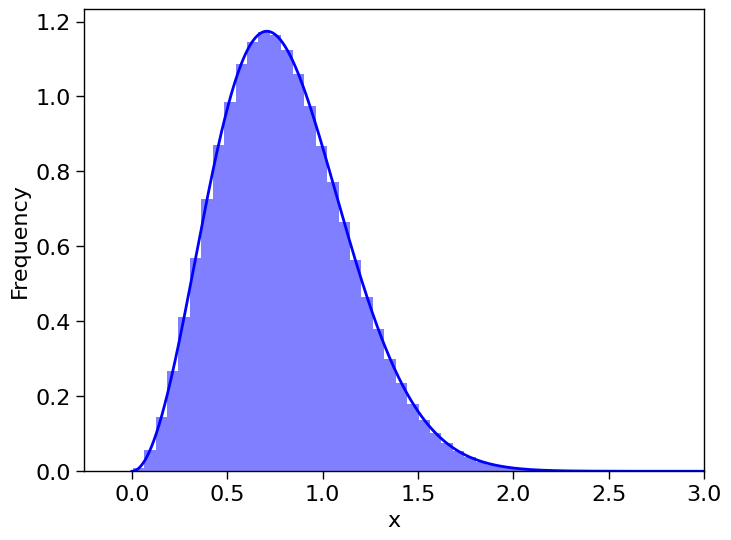

In [111]:
# Distribution of kick magnitudes 

def my_pdf(vk):
    sigma = 0.5 #km/s
    return (np.sqrt(2/np.pi) * (vk**2)/(sigma**3) * np.exp(-1* (vk**2) / (2*sigma**2) ))

# Define the range of x values to consider
x = np.linspace(0, 5, 10000)

# Plot the PDF
plt.plot(x, my_pdf(x),color='b')
plt.xlabel('x')
plt.ylabel('PDF')

# Choose random values from the PDF
num_samples = 10000000 # Number of random samples to choose
samples = np.random.choice(x, size=num_samples, p=my_pdf(x)/np.sum(my_pdf(x)))

# Plot the histogram of the random samples
plt.hist(samples, density=True, bins=50, histtype='stepfilled', lw=3, fc=(0, 0, 1, 0.5))
plt.xlim(right=3)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.show()

In [181]:
get_a2_kick(m1_i = 1, m2_i = 1, m1_n = 0.5, m2_n = 1, e_i = 0.5, a_i = 1, sample=True, N_sample = 1000, zero_kick=False)

(1.43366674510689, 0.5424894997910404)

In [182]:
!pip3 install amuse-framework
!pip3 install amuse


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.4/675.4 kB 842.1 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
  Using cached docutils-0.20.1-py3-none-any.whl (572 kB)
  Created wheel for amuse-framework: filename=amuse_framework-2023.5.0-py3-none-any.whl size=609623 sha256=56404fc2040e3132a6acc8311d44db3f1d4286fa881478ee80faebbc7ad03421
  Stored in directory: /Users/bijan1339/Library/Caches/pip/wheels/26/ea/ae/f99a503950f2c3528f77ec0e22c9fd59d840fc047aab260f3c
Successfully built amuse-framework
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
  Installing build dependencies ... |^C
anceled
ERROR: Operation cancelled by us